In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!git clone https://github.com/LiQianxiao/MaxPrinciple-DeepLearning.git

Cloning into 'MaxPrinciple-DeepLearning'...
remote: Enumerating objects: 28, done.
remote: Total 28 (delta 0), reused 0 (delta 0), pack-reused 28
Unpacking objects: 100% (28/28), done.


In [ ]:
import sys
import os
sys.path.append(os.path.abspath('/content/MaxPrinciple-DeepLearning'))

In [ ]:
%ls

MaxPrinciple-DeepLearning/  sample_data/


In [ ]:
# import yaml
# config = yaml.safe_load(open("MaxPrinciple-DeepLearning/config.yml"))
# config = config['toy']
# config['optimizers'] = [dict({"name":"SGD","lr":0.1}),dict({"name":"Adagrad","lr":0.1}),dict({"name":"Adam","lr":0.005})]
# # config

In [ ]:
import yaml
config = yaml.safe_load(open("MaxPrinciple-DeepLearning/config.yml"))
config = config['mnist']

from msalib.utils import load_dataset
trainset, testset = load_dataset(
  name=config['dataset_name'],
  num_train=config['num_train'],
  num_test=config['num_test'],
  lift_dim=config['lift_dimension']
)
config['num_epochs'] = 10
config['optimizers'] = [dict({"name":"SGD","lr":config['sgd_lr']}),dict({"name":"Adagrad","lr":config['adagrad_lr']}),dict({"name":"Adam","lr":config['adam_lr']})]
config['num_layers'] = 7
config['rho'] = 0.01
config

11493376/11490434 [==============================] - 0s 0us/step


{'activation': 'tanh',
 'adagrad_lr': 0.01,
 'adam_lr': 0.001,
 'batch_size': 128,
 'buffer_size': 512,
 'dataset_name': 'mnist',
 'delta': 0.5,
 'filter_size': 3,
 'lift_dimension': 1,
 'msa_maxiter': 10,
 'msa_perturb_init': 0.0,
 'num_channels': 5,
 'num_epochs': 10,
 'num_layers': 7,
 'num_test': 10000,
 'num_train': 60000,
 'optimizers': [{'lr': 0.01, 'name': 'SGD'},
  {'lr': 0.01, 'name': 'Adagrad'},
  {'lr': 0.001, 'name': 'Adam'}],
 'padding': 'same',
 'print_step': 100,
 'reg': 0.001,
 'rho': 0.01,
 'seed': 1,
 'sgd_lr': 0.01,
 'verbosity': 'WARN'}

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

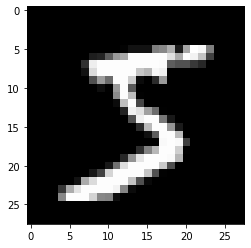

In [ ]:
d, l = trainset.next_batch(10)
from matplotlib import pyplot as plt
tmp=d[0].reshape((28,28))    
plt.imshow(tmp,cmap='gray')
l[0]

In [ ]:
# msalib/layers.py

import tensorflow as tf
import scipy.optimize as sopt
import numpy as np
import tensorflow_probability as tfp

class MSALayer(tf.keras.layers.Layer):
    def __init__(self, *args, 
               msa_rho=0.1, msa_reg=0.1,
               msa_perturb_init=0.0, msa_maxiter=10,
               lbfgs_parallel_iterations = 10,
               msa_trainable=True, **kwargs):
        super().__init__(*args, **kwargs)
        self.msa_rho = tf.constant(msa_rho, dtype=tf.float32, name='msa_rho')
        self.msa_reg = tf.constant(msa_reg, dtype=tf.float32, name='msa_reg')
        self.msa_perturb_init = tf.constant(msa_perturb_init, dtype=tf.float32, name='msa_perturb_init') #msa_perturb_init 
        self.msa_maxiter = tf.constant(msa_maxiter, dtype=tf.int32, name='msa_maxiter') #msa_maxiter 
        self.msa_trainable = tf.constant(msa_trainable, dtype=tf.bool, name='msa_trainable')
        self.lbfgs_parallel_iterations = tf.constant(lbfgs_parallel_iterations, dtype=tf.int32, name='msa_lbfgs_parallel_iterations')
    
    def msa_regularizer(self):
      loss = tf.constant(0.0)
      for w in self.trainable_variables:
        loss = tf.add_n([loss, self.msa_reg * tf.nn.l2_loss(w)])
      return loss

        # if self.trainable_variables:
        #     return self.msa_reg * tf.add_n([
        #         tf.nn.l2_loss(v) for v in self.trainable_variables])
        # else:
        #     return 0.0


    @tf.function
    def msa_hamiltonian(self, x, p):
        return tf.reduce_sum(p * self.call(x))

    @tf.function
    def msa_backward(self, x, p):
        """Compute p_{n}

        Arguments:
            x {tf tensor} -- x_{n}
            p {tf tensor} -- p_{n+1}

        Returns:
            tf tensor -- p_{n}
        """
        H = tf.reduce_sum(p * self(x, training = True))
        return tf.gradients(H, x)[0]

    @tf.function
    def msa_minus_H_aug(self, x, y, p ,q):
        """Computes minus of augmented Hamiltonian
            Note that since p,q are reversed in order,
            (p-q)/dt ~ - dp/dt. This causes some sign reversions

        Arguments:
            x {tf tensor} -- x_{n}
            y {tf tensor} -- x_{n+1}
            p {tf tensor} -- p_{n+1}
            q {tf tensor} -- p_{n}

        Returns:
            tf tensor -- minus of augmented H
        """         
        dHdp = self(x, training = True)
        H = tf.reduce_sum(p * dHdp) - self.msa_regularizer()        
        # H = tf.reduce_sum(p * dHdp) - self.msa_reg * tf.add_n([
        #     tf.nn.l2_loss(v) for v in self.trainable_variables])
        dHdx = tf.gradients(H, x, stop_gradients=[x, y, p, q])[0]
        x_feasibility = self.msa_rho * tf.nn.l2_loss(y - dHdp)
        p_feasibility = self.msa_rho * tf.nn.l2_loss(q - dHdx)
        return - H + x_feasibility + p_feasibility

    @tf.function
    def assign_trainable_variables(self, w):
        a = tf.TensorArray(tf.float32, size = len(w))
        a = a.split(w, lengths=tf.repeat(1, len(w)))
        offset = tf.constant(0)
        for w in self.trainable_variables:
          s = w.shape
          v = tf.reduce_prod(s)
          w.assign(tf.reshape(a.gather(tf.range(offset, v + offset)), s))
          offset = tf.add_n([offset, v])

    @tf.function
    def optimize(self, x, y, p, q):
      # trainable = tf.where(self.msa_trainable, True, False)
      # if trainable:
        #@tf.function
        # def get_trainable_variables_partition_index():
        #   # tf.print(tf.shape_n(self.trainable_variables))
        #   shapes = tf.shape_n(self.trainable_variables)
        #   n_tensors = len(shapes)
        #   count = 0
        #   idx =  []#tf.TensorArray(tf.int32, size = n_tensors, infer_shape=False) #[] # stitch indices
        #   part = []#tf.TensorArray(tf.int32, size = n_tensors, infer_shape=False) #[] # partition indices          
        #   for i, shape in enumerate(shapes):
        #     n = tf.reduce_prod(shape)
        #     # tf.print(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
        #     idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape)) #idx.write(i, tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
        #     part.append(tf.repeat(i, n)) # part.write(i, tf.repeat(i, n))
        #     count += n
          
        #   part = tf.concat(part, axis=0)
        #   return part, idx

        @tf.function
        def g(w):                              
          self.assign_trainable_variables(w)
          loss = self.msa_minus_H_aug(x, y, p, q)
          dLdw = tf.gradients(loss, self.trainable_variables)
          a = tf.TensorArray(tf.float32, size=len(dLdw), infer_shape = False)
          i = 0
          for v in dLdw:
            a = a.write(i, tf.reshape(v, [-1]))
            i += 1
          return loss, a.concat()
                
        a = tf.TensorArray(tf.float32, size=len(self.trainable_variables), infer_shape = False)
        i = 0
        for w in self.trainable_variables:
          a = a.write(i, tf.reshape(w, [-1]))
          i += 1      
        v = a.concat()  
        v = tf.add_n([v, self.msa_perturb_init*tf.random.uniform(shape=tf.shape(v), minval=-1.,maxval=1.)])

        # use tfp
        result = tfp.optimizer.lbfgs_minimize(g, 
                                     initial_position=v,
                                     parallel_iterations=10,
                                     max_iterations=self.msa_maxiter)        
        if result.converged:          
          # assign optimised trainable variables
          self.assign_trainable_variables(result.position)
    

    # @tf.function
    # def optimize(self, x, y, p, q):
    #   if len(self.trainable_variables) > 0:
    #     @tf.function
    #     def get_trainable_variables_partition_index():
    #       # tf.print(tf.shape_n(self.trainable_variables))
    #       shapes = tf.shape_n(self.trainable_variables)
    #       n_tensors = len(shapes)
    #       count = 0
    #       idx =  []#tf.TensorArray(tf.int32, size = n_tensors, infer_shape=False) #[] # stitch indices
    #       part = []#tf.TensorArray(tf.int32, size = n_tensors, infer_shape=False) #[] # partition indices          
    #       for i, shape in enumerate(shapes):
    #         n = tf.reduce_prod(shape)
    #         # tf.print(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
    #         idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape)) #idx.write(i, tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
    #         part.append(tf.repeat(i, n)) # part.write(i, tf.repeat(i, n))
    #         count += n
          
    #       part = tf.concat(part, axis=0)
    #       return part, idx

    #     @tf.function
    #     def g(w):                              
    #       # with tf.GradientTape() as g:
    #       #   g.watch(w)
    #       #   params = tf.dynamic_partition(w, part, size)
    #       #   for i, (shape, param) in enumerate(zip(shapes, params)):
    #       #     self.trainable_variables[i].assign(tf.reshape(param, shape))
    #       #   loss = self.msa_minus_H_aug(x, y, p, q)
    #       # dLdw = g.gradient(loss, self.trainable_variables)            
    #       params = tf.dynamic_partition(w, part, size)
    #       for i, (shape, param) in enumerate(zip(shapes, params)):
    #         self.trainable_variables[i].assign(tf.reshape(param, shape))
    #       loss = self.msa_minus_H_aug(x, y, p, q)
    #       dLdw = tf.gradients(loss, self.trainable_variables)
    #       return loss, tf.dynamic_stitch(idx, dLdw)
                
    #     part, idx = get_trainable_variables_partition_index()
        
    #     shapes = tf.shape_n(self.trainable_variables)
    #     size = len(shapes)
      
    #     v = tf.dynamic_stitch(idx, self.trainable_variables)        
    #     # if self.msa_perturb_init:
    #     v += self.msa_perturb_init*tf.random.uniform(shape=tf.shape(v), minval=-1.,maxval=1.)

    #     # # use scipy lbfgs        
    #     # def func(x):
    #     #   return [tf.cast(vv, tf.float64).numpy() for vv in g(tf.cast(x, dtype=tf.float32))]

    #     # # def lbfgs(x0, perturb):
    #     # #   x0 = x0.numpy()
    #     # #   if perturb:
    #     # #     x0 += perturb*np.random.uniform(low=-1.0, high=1.0, size=x0.shape)
    #     # #   resdd = sopt.minimize(fun=func, x0=x0, jac=True, method='L-BFGS-B')
    #     # #   return resdd.x        
    #     # # pos = tf.py_function(func=lbfgs, inp=[v, self.msa_perturb_init], Tout=tf.float32)

    #     # resdd = sopt.minimize(fun=func, x0=v.numpy(), jac=True, method='L-BFGS-B',options={'maxiter':self.msa_maxiter})
    #     # pos = tf.constant(resdd.x, dtype=tf.float32)

    #     # use tfp
    #     result = tfp.optimizer.lbfgs_minimize(g, 
    #                                  initial_position=v,
    #                                  max_iterations=self.msa_maxiter)        
    #     if result.converged:          
    #       # assign optimised trainable variables
    #       params = tf.dynamic_partition(result.position, part, size)
    #       for i, (shape, param) in enumerate(zip(shapes, params)):
    #         self.trainable_variables[i].assign(tf.reshape(param, shape))        
    
    
class Dense(tf.keras.layers.Dense, MSALayer):
    pass

class ResidualDense(MSALayer):
    def __init__(self, *args, delta=0.1, 
                 units=32, activation='tanh',
                 seed=1,                
                 kernel_init=0.1,
                 bias_init=0.1, **kwargs):
        super().__init__(*args, **kwargs)
        self.units = units
        self.delta = tf.constant(delta, dtype=tf.float32, name='msa_delta')
        self.seed = seed        
        self.kernel_init = kernel_init
        self.bias_init = bias_init
        self.activation = tf.keras.activations.get(activation)
    
    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[-1], self.units),
                                      initializer=tf.compat.v1.truncated_normal_initializer(stddev=self.kernel_init, seed=self.seed), 
                                      trainable=True)
        self.bias = self.add_weight(name='bias',
                                    shape=(self.units,),
                                    initializer=tf.keras.initializers.Constant(value=self.bias_init),
                                    trainable=True)
        
    def call(self, inputs, training=False):
        return inputs + self.delta*self.activation(tf.matmul(inputs, self.kernel) + self.bias)
  

class Conv2D(tf.keras.layers.Conv2D, MSALayer):
    pass
    # def call(self, inputs, training=False):
    #   return tf.keras.layers.Conv2D.call(inputs)


class ResidualConv2D(Conv2D):
    """Residual connection conv2d layer
        This is slightly different from the usual ResNet
        in that there is only 1 conv layer, instead of 2
    """
    def __init__(self, *args, delta=0.1, **kwargs):
      super().__init__(*args, **kwargs)
      self.delta = tf.constant(delta, dtype=tf.float32, name='msa_delta')
    
    def call(self, inputs):
      return inputs + self.delta*super().call(inputs)

class MFResidualConv2D(Conv2D):
    """Mean field Residual connection conv2d layer
        This is slightly different from the usual ResNet
        in that there is only 1 conv layer, instead of 2
    """
    def __init__(self, *args, delta=0.1, **kwargs):
      super().__init__(*args, **kwargs)
      self.delta = tf.constant(delta, dtype=tf.float32, name='msa_delta')
      self.is_bnlayer = True
      self.bnlayer = tf.keras.layers.BatchNormalization()
    
    def call(self, inputs, training = False):
      return inputs + self.delta*super().call(self.bnlayer(inputs, training = training))


class Lower(MSALayer):
    """Lower dimension layer
    """

    def __init__(self, *args, lower_axis=-1, **kwargs):
        super().__init__(*args, **kwargs)
        self.lower_axis = lower_axis
        self.msa_trainable = tf.constant(False, dtype=tf.bool, name='msa_trainable')


class Flatten(tf.keras.layers.Flatten, MSALayer):
    """Flatten layer
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.msa_trainable = tf.constant(False, dtype=tf.bool, name='msa_trainable')


class AveragePooling2D(tf.keras.layers.AveragePooling2D, MSALayer):
    """Average pooling layer
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.msa_trainable = tf.constant(False, dtype=tf.bool, name='msa_trainable')
    

In [ ]:
# msalib/network.py

import tensorflow as tf

class Network(tf.keras.Sequential):
    """Network class combining MSA layers
    """
    
    def add_loss_func(self, loss_func):
      self.loss_func = loss_func

    @tf.function
    def msa_compute_pn(self, label, y):
      return -tf.gradients(self.loss_func(label, y), y)[0]

    @tf.function
    def msa_train(self, input, label):
      # compute xs
      x = input
      xs = [x]
      for layer in self.layers:
        x = layer(x, training = True)
        xs.append(x)

      # compute ps        
      y = xs[-1]
      p = self.msa_compute_pn(label, y)
      ps = [p]
      xs = list(reversed(xs))
      for i, layer in enumerate(reversed(self.layers)):
        p = layer.msa_backward(xs[i+1] , p)
        ps.append(p)

      # optimize
      xs = list(reversed(xs))
      ps = list(reversed(ps))
      for n, layer in enumerate(self.layers):
        if layer.msa_trainable:
          x = xs[n]
          y = xs[n+1]
          p = ps[n+1]
          q = ps[n]
          layer.optimize(x,y,p,q)

    # @tf.function
    # def msa_train(self, input, label):
    #     s = len(self.layers) + 1
    #     tx = tf.TensorArray(tf.float32, size=s, infer_shape=False)
    #     tx = tx.write(0, input)
        
    #     i = 0
    #     for layer in self.layers:
    #       tx = tx.write(i+1, layer.call(tx.read(i)))
    #       i += 1
    #       # tx = tx.write(i+1, layer.output)
        
    #     tp = tf.TensorArray(tf.float32, size=s, infer_shape=False)
    #     y = tx.read(s - 1)
    #     p = -tf.gradients(self.loss_func(label, y), y)[0]
    #     tp = tp.write(s - 1, p)

    #     i = 0
    #     for layer in reversed(self.layers):
    #       p = layer.msa_backward(tx.read(s - i - 2), p)
    #       tp = tp.write(s - i - 2, p)
    #       i += 1

    #     n = 0
    #     for layer in self.layers:
    #       if layer.msa_trainable:                                
    #         x = tx.read(n)
    #         y = tx.read(n+1)
    #         p = tp.read(n+1)
    #         q = tp.read(n)
    #         layer.optimize(x,y,p,q)
    #       n += 1

    # # @tf.function
    # def msa_compute_x(self, input):
    #     """Compute the states

    #     Arguments:
    #         x {tf tensor} -- initial state
    #     """        
    #     s = len(self.layers) + 1
    #     ta = tf.TensorArray(tf.float32, size=s, infer_shape=False)        
    #     x = input
    #     ta = ta.write(0, x)
    #     for i, layer in enumerate(self.layers):
    #         x = layer(x, training = True)            
    #         ta = ta.write(i + 1, x)
    #         self.msa_xs = ta

    # @tf.function
    # def msa_train(self, input, label):
    #     self.msa_compute_x(input)
    #     self.msa_compute_p(label)
    #     xs = self.msa_xs.stack()
    #     ps = self.msa_ps.stack()
    #     self.ph_xs = xs[:-1]
    #     self.ph_ys = xs[1:]
    #     self.ph_ps = ps[1:]
    #     self.ph_qs = ps[:-1]
    #     for n, layer in enumerate(self.layers):
    #         if layer.msa_trainable:                
    #             x = self.ph_xs[n]
    #             y = self.ph_ys[n]
    #             p = self.ph_ps[n]
    #             q = self.ph_qs[n]
    #             layer.optimize(x,y,p,q)
    #             # tf.py_function(func=layer.optimize, inp=[x,y,p,q], Tout=[]) #layer.optimize(x, y, p, q)
    

    # @tf.function
    # def test_msa(self, input, label):
    #     self.msa_compute_x(input)
    #     self.msa_compute_p(label)
    #     # @tf.function
    #     # def opt(n):          
    #     #   x = self.msa_xs.read(n)
    #     #   y = self.msa_xs.read(n+1)
    #     #   p = self.msa_ps.read(n+1)
    #     #   q = self.msa_ps.read(n)
    #     # tf.map_fn(opt, tf.range(0,len(self.layers)))
    #     for n, layer in enumerate(self.layers):
    #         if layer.msa_trainable:                
    #             # tf.print(n)
    #             x = self.msa_xs.read(n)
    #             y = self.msa_xs.read(n+1)
    #             p = self.msa_ps.read(n+1)
    #             q = self.msa_ps.read(n)
    #             # tf.py_function(func=layer.optimize, inp=[x,y,p,q], Tout=[])
    #             layer.optimize(x,y,p,q)
      
    #     # s = len(self.layers) + 1
    #     # ta = tf.TensorArray(tf.float32, size = s, infer_shape= False)
    #     # x = input
    #     # ta = ta.write(0, x)
    #     # tf.print(x.shape)
    #     # for i, layer in enumerate(self.layers):            
    #     #     x = layer.msa_forward(x)
    #     #     tf.print(x.shape)
    #     #     ta = ta.write(i + 1, x)
    #     # p = -tf.gradients(self.loss_func(label, x), x)[0]
    #     # for i, layer in enumerate(reversed(self.layers)):
    #     #   r = ta.gather([i,i])
    #     #   tf.print(r.shape)
    #       # p = layer.msa_backward(ta.gather([s - i - 2,s - i - 2]),p)

    #     # s = len(self.layers) + 1
    #     # self.msa_xs = tf.TensorArray(tf.float32, size=s, infer_shape=False)        
    #     # return self(input)
    #     # for layer in self.layers:
    #     #     tf.print(layer.output)
    #     # for i in tf.range(0, s-1):
    #     #     tf.print(i)
    #     #     self.get_layer(index=tf.constant(i))
    #         # input = l(input, training = True)            
    #         # self.msa_xs = self.msa_xs.write(i + 1, input)    
    #     # return self.msa_xs.gather([3,3])

    # # @tf.function
    # # def test_msa_p(self, label):
    # #     l = len(self.layers)
    # #     y = self.layers[-1].
    # #     p = -tf.gradients(self.loss_func(label, y), y)[0]
    # #     for layer in reversed(self.layers):
    # #       p = layer.msa_backward(p)
    #     # s = l + 1
    #     # self.msa_ps = tf.TensorArray(tf.float32, size=s, infer_shape=False)
    #     # self.msa_ps = self.msa_ps.write(s-1, p)
    #     # for i in tf.range(0, l):
    #     #     layer = self.layers[s-i-1]
    #     #     p = layer.msa_backward(self.msa_xs.gather([s-i-1, s-i-1]), p)
    #     #     self.msa_ps = self.msa_ps.write(s-i-1, p)
    #     # self.msa_ps = tf.TensorArray(tf.float32, size=s)
    #     # self.msa_ps = self.msa_ps.unstack(tf.reverse(ta.stack(), [0]))


    # # def msa_compute_p(self, label):
    # #     """Compute the co-states

    # #     Arguments:
    # #         label {tf tensor} -- labels (y_true)
    # #         loss_func {function returning tf tensor} -- loss function(y_true, y_pred)
    # #     """
    # #     xs = self.msa_xs.stack()
    # #     y = xs[-1]
    # #     p = -tf.gradients(self.loss_func(label, y), y)[0]
    # #     s = len(self.layers) + 1
    # #     ta = tf.TensorArray(tf.float32, size=s, infer_shape=False)
    # #     ta = ta.write(0, p)
    # #     xs = tf.reverse(xs[:-1],[0])
    # #     for i, layer in enumerate(reversed(self.layers)):
    # #         p = layer.msa_backward(xs[i], p)
    # #         ta = ta.write(i + 1, p)
    # #     self.msa_ps = tf.TensorArray(tf.float32, size=s)
    # #     self.msa_ps = self.msa_ps.unstack(tf.reverse(ta.stack(), [0]))
         
    # # def msa_compute_x(self, input):
    # #     """Compute the states

    # #     Arguments:
    # #         x {tf tensor} -- initial state
    # #     """        
    # #     # s = len(self.layers) + 1
    # #     self.msa_xs = [input] #tf.TensorArray(tf.float32, size=s)
    # #     tf.print(input.shape)
    # #     # self.msa_xs = self.msa_xs.write(0, input)        
    # #     for i, l in enumerate(self.layers):
    # #         input = l(input, training = True)
    # #         tf.print(input.shape)
    # #         self.msa_xs.append(input) #= self.msa_xs.write(i + 1, input)    



    # # def msa_compute_x(self, input):
    # #     """Compute the states

    # #     Arguments:
    # #         x {tf tensor} -- initial state
    # #     """        
    # #     s = len(self.layers) + 1
    # #     self.msa_xs = tf.TensorArray(tf.float32, size=s)
    # #     self.msa_xs = self.msa_xs.write(0, input)
    # #     for i, l in enumerate(self.layers):
    # #         input = l(input, training = True)
    # #         self.msa_xs = self.msa_xs.write(i + 1, input)    

    # # @tf.function
    # def msa_compute_p(self, label):
    #     """Compute the co-states

    #     Arguments:
    #         label {tf tensor} -- labels (y_true)
    #         loss_func {function returning tf tensor} -- loss function(y_true, y_pred)
    #     """
    #     # xs = self.msa_xs.stack()        
    #     s = len(self.layers) + 1
    #     xs = self.msa_xs
    #     y = xs.read(s-1)
    #     p = -tf.gradients(self.loss_func(label, y), y)[0]
    #     ta = tf.TensorArray(tf.float32, size=s, infer_shape=False)
    #     ta = ta.write(s-1, p)
    #     x = xs.read(s-2)
    #     for i, layer in enumerate(reversed(self.layers)):
    #       x = xs.read(s - i - 2) 
    #       p = layer.msa_backward(x, p)
    #       ta = ta.write(s - i -2, p)
    #     self.msa_ps = ta

    #     # with tf.GradientTape() as g:
    #     #   g.watch(y)
    #     #   z = self.loss_func(label, y)
    #     # p = -g.gradient(z, y)
    #     #p = tf.gradients(self.loss_func(label, y), y)
    #     # tf.print(p)
    #     # ta = tf.TensorArray(tf.float32, size=s, infer_shape=False)
    #     # ta = ta.write(0, p)
    #     # # xs = self.msa_xs.gather([0, s-1])
    #     # # xs = tf.reverse(self.msa_xs[:-1],[0])                
    #     # layer = self.get_layer(index= s-2)
    #     # xs = self.msa_xs
    #     # x = xs.gather([s-2, s-2])
    #     # tf.print(p)
    #     # layer.msa_backward(x, p)
    #     # self.msa_ps
    #     # for i, layer in enumerate(reversed(self.layers)):
    #     #   x = xs.gather([s - i - 2, s - i - 2])
    #     #   # tf.print(x)
    #     #   p = layer.msa_backward(x, p)            
    #       # self.msa_ps = self.msa_ps.write(i + 1, p)
    #         # ta = ta.write(i + 1, p)
    #     # self.msa_ps = tf.TensorArray(tf.float32, size=s)
    #     # self.msa_ps = self.msa_ps.unstack(tf.reverse(ta.stack(), [0]))

    

        

In [ ]:
def loss_func(label, output):
    """Loss function (softmax cross entropy)

    Arguments:
        output {tf tensor} -- output from network
        label {tf tensor} -- labels

    Returns:
        tf tensor -- loss
    """    
    # return tf.compat.v1.losses.softmax_cross_entropy(label, output)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)    
    return cce(label, output)        


In [ ]:
# a, b = trainset.next_batch(10)

In [ ]:
# net = Network(name="msa_mnist_net")
# net.add_loss_func(loss_func)
# net.add(Conv2D(
#     input_shape=(28,28,config['lift_dimension']),
#     filters=config['num_channels'],
#     kernel_size=config['filter_size'],
#     padding=config['padding'],
#     activation=config['activation'],
#     msa_rho=config['rho'],
#     msa_reg=config['reg'],
#     name='conv2d_0')
# )
# net.add(AveragePooling2D(
#     pool_size=2, strides=2, padding=config['padding'], name='avg_pool_0')
# )
# net.add(Conv2D(
#     input_shape=(28,28,config['lift_dimension']),
#     filters=config['num_channels'],
#     kernel_size=config['filter_size'],
#     padding=config['padding'],
#     activation=config['activation'],
#     msa_rho=config['rho'],
#     msa_reg=config['reg'],
#     name='conv2d_init')    
# )
# net.add(AveragePooling2D(
#     pool_size=2, strides=2, padding=config['padding'], name='avg_pool_1')
# )
# net.add(Lower(name='lower'))
# net.add(Flatten(name='flatten'))
# net.add(Dense(units=10, msa_rho=config['rho'], msa_reg=config['reg'], name='dense'))

# # net(a).shape
# net.summary()
# # y=net(a)

def createModel():
  net = Network(name="msa_mnist_net")
  net.add_loss_func(loss_func)
  net.add(Conv2D(
    input_shape=(28,28,config['lift_dimension']),
    filters=config['num_channels'],
    kernel_size=config['filter_size'],
    padding=config['padding'],
    activation=config['activation'],
    msa_rho=config['rho'],
    msa_reg=config['reg'],
    name='conv2d_0')
  )
  net.add(AveragePooling2D(
    pool_size=2, strides=2, padding=config['padding'], name='avg_pool_0')
  )
  net.add(Conv2D(
    input_shape=(28,28,config['lift_dimension']),
    filters=config['num_channels'],
    kernel_size=config['filter_size'],
    padding=config['padding'],
    activation=config['activation'],
    msa_rho=config['rho'],
    msa_reg=config['reg'],
    name='conv2d_init')    
  )
  net.add(AveragePooling2D(
    pool_size=2, strides=2, padding=config['padding'], name='avg_pool_1')
  )
  for n in range(config['num_layers']):
    net.add(ResidualConv2D(
      filters=config['num_channels'],
      kernel_size=config['filter_size'],
      padding=config['padding'],
      activation=config['activation'],
      msa_rho=config['rho'],
      msa_reg=config['reg'],
      delta=config['delta'],
      name='residualconv2d_{}'.format(n)
    ))
  net.add(Lower(name='lower'))
  net.add(Flatten(name='flatten'))
  net.add(Dense(units=10, msa_rho=config['rho'], msa_reg=config['reg'], name='dense'))
  return net


def createMFModel():
  net = Network(name="mf_msa_mnist_net")
  net.add_loss_func(loss_func)
  net.add(Conv2D(
    input_shape=(28,28,config['lift_dimension']),
    filters=config['num_channels'],
    kernel_size=config['filter_size'],
    padding=config['padding'],
    activation=config['activation'],
    msa_rho=config['rho'],
    msa_reg=config['reg'],
    name='conv2d_0')
  )
  net.add(AveragePooling2D(
    pool_size=2, strides=2, padding=config['padding'], name='avg_pool_0')
  )
  net.add(Conv2D(
    input_shape=(28,28,config['lift_dimension']),
    filters=config['num_channels'],
    kernel_size=config['filter_size'],
    padding=config['padding'],
    activation=config['activation'],
    msa_rho=config['rho'],
    msa_reg=config['reg'],
    name='conv2d_init')    
  )
  net.add(AveragePooling2D(
    pool_size=2, strides=2, padding=config['padding'], name='avg_pool_1')
  )
  for n in range(config['num_layers']):
    net.add(MFResidualConv2D(
      filters=config['num_channels'],
      kernel_size=config['filter_size'],
      padding=config['padding'],
      activation=config['activation'],
      msa_rho=config['rho'],
      msa_reg=config['reg'],
      delta=config['delta'],
      name='residualconv2d_{}'.format(n)
    ))
  net.add(Lower(name='lower'))
  net.add(Flatten(name='flatten'))
  net.add(Dense(units=10, msa_rho=config['rho'], msa_reg=config['reg'], name='dense'))
  return net



In [ ]:
# msalib/train.py

import tensorflow as tf
import math

class Trainer(object):
    """Abstract trainer object
    """

    def __init__(self, network, name, **kwargs):
        """Abstract trainer object

        Arguments:
            network {Network object} -- network
            name {string} -- name
        """

        self.network = network
        self.name = name
        self.kwargs = kwargs
        self._add_train_ops()


    def loss_func(self, label, output):
        """
        label, output = y_true, y_pred
        """
        return self.network.loss_func(label, output) + \
            tf.add_n([l.msa_regularizer() for l in self.network.layers])

    def add_train_ops(self):
        raise NotImplementedError

    def _compute_loss(self, dataset, buffer_size):
        # TODO: Iterators with tf.dataset API
        loss = 0
        num_steps = math.ceil(dataset.num_examples / buffer_size)
        for step in range(num_steps):
            input_batch, label_batch = dataset.next_batch(buffer_size)
            loss += self.loss_func(label_batch, self.network(input_batch))
        return loss / num_steps

    def _train_step(self, dataset, batch_size):
        raise NotImplementedError

    def _train_epoch(self, trainset, testset, batch_size,
                     buffer_size, print_step=False):
        num_steps = math.ceil(trainset.num_examples / batch_size)
        for step in range(num_steps):
            self._train_step(trainset, batch_size)
            if print_step and step % math.ceil(num_steps / print_step) == 0:
                train_loss = self._compute_loss(trainset, buffer_size)
                test_loss = self._compute_loss(testset, buffer_size)
                print('Step {:5} of {:5}: '.format(step, num_steps))
                print('Train loss: {}'.format(train_loss))
                print('Test loss: {}'.format(test_loss))

    def train(self, trainset, testset, batch_size,
              num_epochs, buffer_size=500, print_step=False):
        """Train epoch

        Arguments:
            session {tf session} -- session
            trainset {Dataset object} -- training set
            testset {Dataset object} -- testing set
            batch_size {int} -- batch size
            num_epochs {int} -- number of epochs to train

        Keyword Arguments:
            buffer_size {int} -- buffer size for feed_dict (default: {500})
            print_step {bool} -- print step losses (default: {False})
        """
        epochs = []
        train_losses = []
        test_losses = []

        print('='*100)
        print('Trainer: {} ({})'.format(self.__class__.__name__, self.name))
        print('Settings: {}'.format(getattr(self, 'kwargs', 'none')))
        print('='*100)
        print('Epoch: init')
        init_train_loss = self._compute_loss(trainset, buffer_size)
        train_losses.append(init_train_loss)
        print('Init train loss: {}'.format(init_train_loss))
        init_test_loss = self._compute_loss(testset, buffer_size)
        test_losses.append(init_test_loss)
        print('Init test loss: {}'.format(init_test_loss))

        for epoch in range(num_epochs):
            self._train_epoch(trainset, testset, batch_size, buffer_size, print_step)
            print('Epoch: {}'.format(epoch))
            train_loss = self._compute_loss(trainset, buffer_size)
            print('Train loss: {}'.format(train_loss))
            test_loss = self._compute_loss(testset, buffer_size)
            print('Test loss: {}'.format(test_loss))
            epochs.append(epoch)
            train_losses.append(train_loss)
            test_losses.append(test_loss)

        return epochs, train_losses, test_losses

class MSATrainer(Trainer):
    """Implementation of the E-MSA algorithm
    """

    def _add_train_ops(self):
        pass

    def _train_step(self, dataset, batch_size):
        # perturb_init = self.kwargs['perturb_init']
        # maxiter = self.kwargs['maxiter']
        input_batch, label_batch = dataset.next_batch(batch_size)        
        input_batch = tf.cast(input_batch, dtype=tf.float32)
        label_batch = tf.cast(label_batch, dtype=tf.float32)
        self.network.msa_train(input_batch, label_batch)

class BPTrainer(Trainer):
    """Trainer for the usual GD-back-prop algorithms
    """

    def _add_train_ops(self):
        opt = tf.keras.optimizers.get(self.kwargs['optimizer_name'])
        opt.learning_rate.assign(self.kwargs['optimizer_lr'])
        self.opt = opt

    def _train_step(self, dataset, batch_size):
        input_batch, label_batch = dataset.next_batch(batch_size)
        with tf.GradientTape() as tape:
          loss_value = self.loss_func(label_batch, self.network(input_batch, training=True))
        grads = tape.gradient(loss_value, self.network.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.network.trainable_variables))




In [ ]:
#plot_logs.py
import matplotlib.pyplot as plt

def plot(result, labels = ['-', ':', '--', '-.']):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))  
  for label, (key, value) in zip(labels,result.items()): 
    ax1.semilogy(value['train_loss'], label, label=key)
  ax1.set_title('Test losses')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.legend()

  for label, (key, value) in zip(labels,result.items()): 
    ax2.semilogy(value['test_loss'], label, label=key)

  ax2.set_title('Train losses')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Loss')
  ax2.legend()

  plt.show()

In [ ]:
# from msalib.utils import Dataset
# import numpy as np
# def generate_datasets(config):
#     """Generate synthetic dataset

#     Arguments:
#         config {dict} -- read from config.yml

#     Returns:
#         tuple of Dataset objects -- train/test sets
#     """

#     np.random.seed(config['seed'])
#     num_train, num_test = config['num_train'], config['num_test']
#     x_train = np.random.uniform(-np.pi, np.pi, (num_train, 1))
#     x_test = np.random.uniform(-np.pi, np.pi, (num_test, 1))
#     y_train, y_test = target(x_train), target(x_test)
#     x_train = np.repeat(x_train, axis=1, repeats=config['num_nodes'])
#     x_test = np.repeat(x_test, axis=1, repeats=config['num_nodes'])
#     trainset = Dataset(data=x_train, target=y_train)
#     testset = Dataset(data=x_test, target=y_test)
#     return trainset, testset

In [ ]:
result={}

trainset, testset = load_dataset(
      name=config['dataset_name'],
      num_train=config['num_train'],
      num_test=config['num_test'],
      lift_dim=config['lift_dimension']
    )


mfnet = createMFModel()
mfnet.build()
mfnet.summary()

msa_mf_trainer = MSATrainer(
    mfnet, name='MSA_MF_MNIST_trainer',
    maxiter=config['msa_maxiter'],
    perturb_init=config['msa_perturb_init']
)

epochs, train_losses, test_losses = msa_mf_trainer.train(
      trainset, testset,
      config['batch_size'],config['num_epochs'],
      config['buffer_size'],config['print_step']
)

result['MSA_MF_MNIST_trainer'] = {'epoch':epochs,'train_loss':train_losses,'test_loss':test_losses}

net = createModel()
net.build()
net.summary()

msa_trainer = MSATrainer(
    net, name='MSA_MNIST_trainer',
    maxiter=config['msa_maxiter'],
    perturb_init=config['msa_perturb_init']
)

epochs, train_losses, test_losses = msa_trainer.train(
      trainset, testset,
      config['batch_size'],config['num_epochs'],
      config['buffer_size'],config['print_step']
)

result['MSA_MNIST_trainer'] = {'epoch':epochs,'train_loss':train_losses,'test_loss':test_losses}


for opt in config['optimizers']:
  trainset, testset = load_dataset(
      name=config['dataset_name'],
      num_train=config['num_train'],
      num_test=config['num_test'],
      lift_dim=config['lift_dimension']
    )
  net = createModel()
  trainer = BPTrainer(
      net, name=opt['name'],
      optimizer_name=opt['name'],
      optimizer_lr=opt['lr']
  )
  epochs, train_losses, test_losses = trainer.train(
      trainset, testset,
      config['batch_size'],config['num_epochs'],
      config['buffer_size'],config['print_step']
  )
  result[opt['name']] = {'epoch':epochs,'train_loss':train_losses,'test_loss':test_losses}

NameError: ignored

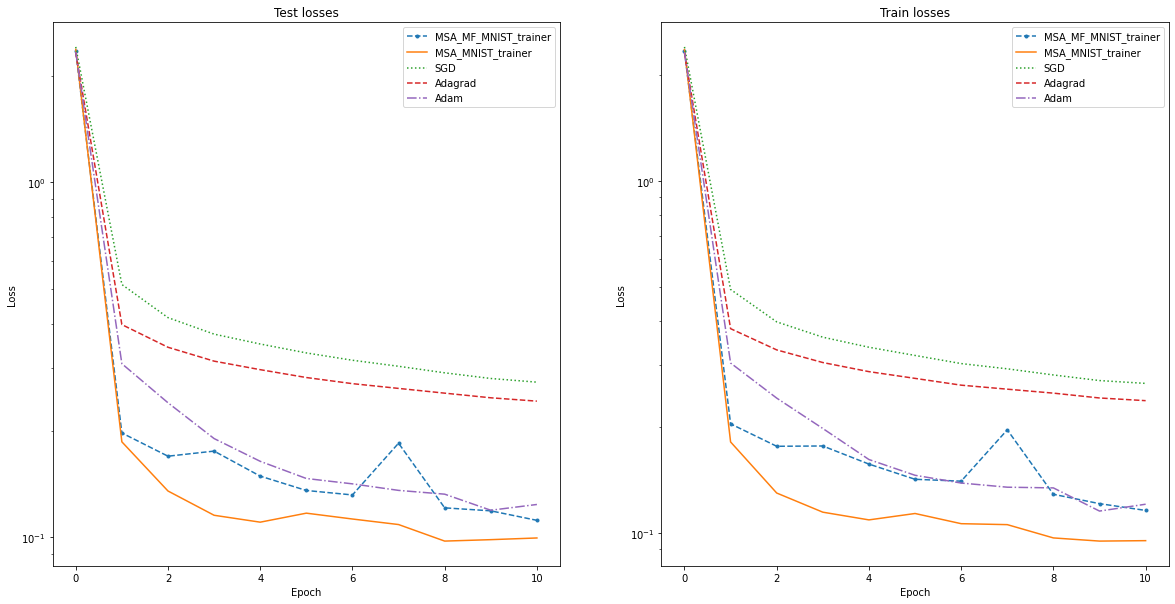

In [ ]:
plot(result, labels=['--.', '-', ':', '--', '-.'])

In [ ]:
# m = createModel()
# trainset, _ = generate_datasets(config)
# input_batch, _ = trainset.next_batch(config['batch_size']) 
# input_batch = tf.cast(input_batch, dtype=tf.float32)

# @tf.function
# def tracemodel(x):
#     return m(x)

# logdir = './logs/msa_network'
# writer = tf.summary.create_file_writer(logdir)
# tf.summary.trace_on(graph=True, profiler=True)
# tracemodel(input_batch)
# with writer.as_default():
#   tf.summary.trace_export(name="msa_network_trace", step=0, profiler_outdir=logdir)

# %load_ext tensorboard
# %tensorboard --logdir ./logs/msa_network/